In [1]:
from preprocessing import *
from visualization_tools import *
import pyriemann
import pyriemann.regression

PATH = '/Users/marco/PROJECTS/F422_PROJECT/data'

In [2]:
# error functions
def RMSE(y_pred, y_val):
    """
    Computes the root mean squared error of y_pred with respect to y_val
    assumes a shape (N, 51)
    """
    return (np.sum((y_val - y_pred)**2)/np.prod(y_val.shape))**0.5

def NMSE(y_pred, y_val):
    """
    Computes the normalized mean squared error of y_pred with respect to y_val
    assumes a shape (N, 51)
    """
    num = np.sum((y_val - y_pred)**2)
    den = np.sum((y_val - np.mean(y_val, axis=0))**2)
    return num/den

In [3]:
# loading raw data
X, Y = load_data(
    x_path = PATH + '/guided/guided_dataset_X.npy',
    y_path = PATH + '/guided/guided_dataset_Y.npy'
)

# optional -  restrict to a single bone
bone = 7
Y = Y[:,bone*3:(bone+1)*3,:]

# creating the time windows and the labels
window_size = 500
window_step = 100
X_windows = create_time_windows(X, size = window_size, step = window_step)
Y_labels = create_labels(Y, size = window_size, step = window_step)

In [4]:
scores = np.zeros((4,2))
for fold in range(4):
    # splitting sessions into train and validation --- always keep fifth session out for model selection
    train_sessions = [0,1,2,3]
    train_sessions.remove(fold)
    X_train, Y_train, X_val, Y_val = split_sessions(
        X_windows, Y_labels,
        train_sessions = train_sessions,
        val_session = fold
    )

    # stacking the training sessions together
    n_sessions = X_train.shape[0]
    n_windows = X_train.shape[1]
    X_train_stacked = X_train.reshape(n_sessions*n_windows, *X_train.shape[2:])
    Y_train_stacked = Y_train.reshape(n_sessions*n_windows, *Y_train.shape[2:])

    # computing the covariance matrices
    estimator = 'cov'
    cov = pyriemann.estimation.Covariances(estimator)
    X_train_covariances = cov.fit_transform(X_train_stacked)
    X_val_covariances = cov.fit_transform(X_val)

    # training SVM model
    metric = 'riemann'
    SVR = pyriemann.regression.SVR(metric=metric)
    Y_pred_labels = np.zeros_like(Y_val)
    for i in range(Y_val.shape[-1]):
        SVR.fit(X_train_covariances, Y_train_stacked[:, i])
        Y_pred_labels[:,i] = SVR.predict(X_val_covariances)

    scores[fold,0] = RMSE(Y_pred_labels, Y_val)
    scores[fold,1] = NMSE(Y_pred_labels, Y_val)

    print('Fold', fold)
    print('RMSE:', scores[fold,0])
    print('NMSE:', scores[fold,1])
    print('\n')

print('Average RMSE:', np.mean(scores[:,0]))
print('Average NMSE:', np.mean(scores[:,1]))

Fold 0
RMSE: 4.950773606819648
NMSE: 0.2307824834306999


Fold 1
RMSE: 4.586339953490512
NMSE: 0.1938970830612884


Fold 2
RMSE: 5.866599763484802
NMSE: 0.24468253047955452


Fold 3
RMSE: 5.56533727566817
NMSE: 0.24639410148272442


Average RMSE: 5.242262649865784
Average NMSE: 0.22893904961356681


<Axes3D: >

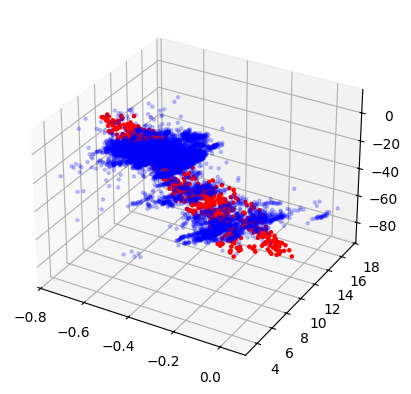

In [15]:
ax = scatter_3d_points(Y_pred_labels, color='r')
scatter_3d_points(Y_train_stacked, ax=ax, color='b', alpha = 0.2)